# Importing the libraries we will need


In [71]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize,scale
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
%matplotlib inline


# *Familiarization task*

For the familiarization task we are going to read our datasets (by using the pandas library) and examine them.

To do so, we firstly define the path that leads to our datasets.

In [95]:
attack_data_path = os.path.join('data', 'SWaT_Dataset_Attack_v0.csv')
normal_data_path = os.path.join('data', 'SWaT_Dataset_Normal_v0.csv')

print("Path of the attack dataset: %s" %attack_data_path)
print("Path of the normal dataset: %s" %normal_data_path)


Path of the attack dataset: data/SWaT_Dataset_Attack_v0.csv
Path of the normal dataset: data/SWaT_Dataset_Normal_v0.csv


# Read the data and initial pre-processing

The "read_from_file()" function below, converts the csv into a pandas dataframe.
The initial pre-processing that we do is:
* skip the first line (it is empty)
* skip blank lines 
* convertion of the labels {Normal, Attack} to {0, 1} (0 = Normal, 1 = Attack). In this step we realized that some "Attack" labels were written as "A ttack" so we labeled them as 1 too.

This function returns two pandas dataframes, one for the attack dataset and another one for the normal dataset.

In [96]:
def read_from_file():
    print("Reading Attack and Normal dataset from file.")
    converters = {'Normal/Attack': lambda x: 1 if (x == "A ttack" or x == "Attack") else 0}

    attack_data = pd.read_csv(attack_data_path, skip_blank_lines=True, skiprows=1, converters=converters)
    normal_data = pd.read_csv(normal_data_path, skip_blank_lines=True, skiprows=1, converters=converters)
    print("\t\tDone.")
    return attack_data, normal_data

Now we are able to read our datasets.

In [97]:
attack_data, normal_data = read_from_file()

Reading Attack and Normal dataset from file.
		Done.


# Examination of our data
Let's find out how many columns do our csv files have and if both datasets contain the same columns.

In [98]:

normal_data.rename(columns = {' Timestamp':'Timestamp'}, inplace = True)
attack_data.rename(columns = {' AIT201':'AIT201', ' MV101': 'MV101', ' P201':'P201', ' MV201': 'MV201'}, inplace = True)

# Remove the whitespaces from the column names
strip = lambda container: map(lambda element: element.strip(), container)
attack_data.columns = strip(attack_data.columns.tolist())
normal_data.columns = strip(normal_data.columns.tolist())

print len(list(normal_data))
print (len(list(attack_data)))
print(list(attack_data) == list(normal_data))


53
53
True


Thus, we have the same 53 columns in both datasets.

Let's find out the names of those columns.

In [99]:
print list(attack_data)

['Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603', 'Normal/Attack']


# Dataset

As we can observe, there are not all the 53 columns about the recorded signals' values. One corresponds to 'Timestamp' and another one to 'Normal/Attack' (labels). 

The rest (51) are the recorded signals. In https://itrust.sutd.edu.sg/wp-content/uploads/sites/3/2015/11/Brief-Introduction-to-SWaT_181115.pdf we found the explanation of what those signals mean. 

In general they are divided in analog and digital signals. 

(From the list of the digital signals we only have P, MV, UV).

## Analog

![title](img/analog.png)

## Digital

![title](img/digital.png)

Thus, let's now answer the first two questions of the assignment.

##  *How	many	different	types	of	signals	are	there?	What	types	of	signals	are	these?*

There are 51 different types of signals which could be divided into two basic types: Analog and digital. 

More information is provided by the two images above.

## *Are	the	signals	correlated?*

To find the correlation between the signals we first combined the two datasets into one.


In [100]:
frames = [normal_data, attack_data]
combined = pd.concat(frames)

# Remove labels
del combined["Normal/Attack"]


Then, we compute the correlation matrix.

In [101]:
# compute the correlation matrix
corr = combined.corr()

## *Visualize these types and the presence or absence of correlation*


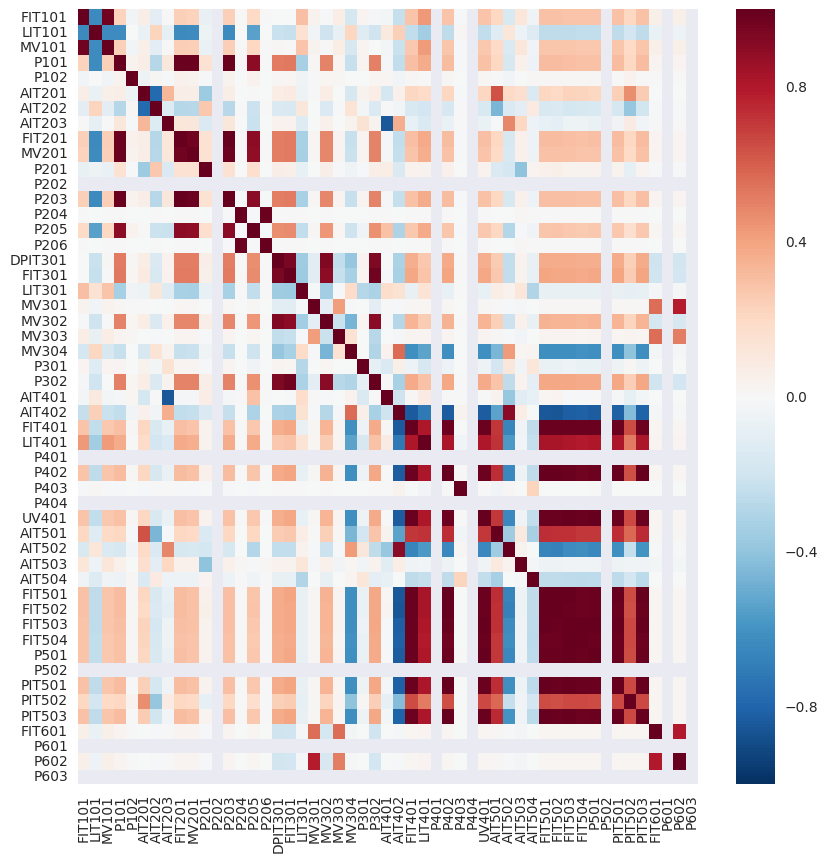

In [102]:
# visualization of the correlation matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(corr)#, xticklabels=corr.columns,yticklabels=corr.columns)

The above plot suggests that there are some correlations, especially between signals of the same type.

In addition, FIT (flow), PIT (pressure) and PS (pressure switch) signals seem to correlate significantly. 

The rest of the data do not correlate so much with each other.

# *Separate the data into training and testing. Use the data until the day of the first anomaly as training.*

To do that, we implemented the function "pre-process". This function does the following:
* Remove whitespaces from the names of the columns (in both dataframes {normal, attack} )
* Finds the index of the first record which is labeled as attack
* Creates two dataframes: one with all the records until the first attack (training set) and another one with the rest of them.
* Removes columns which have less than three different values (they do not offer useful information neither on PCA or in ARMA method).
* Returns the two dataframes

In [103]:
def pre_process(attack_df, normal_df):
    print("Pre-processing and creating training and testing sets.")
    # Remove the whitespaces from the column names
    strip = lambda container: map(lambda element: element.strip(), container)
    attack_df.columns = strip(attack_df.columns.tolist())
    normal_df.columns = strip(normal_df.columns.tolist())

    print("* Splitting in training and testing set")
    # Create training and testing data frames
    first_attack_row_index = -1
    for index, row in attack_df.iterrows():
        if row['Normal/Attack'] == 1:
            first_attack_row_index = index
            break

    df_before_attack = attack_df.iloc[:first_attack_row_index, :]
    training_set = pd.concat([normal_df, df_before_attack])
    testing_set = attack_df.iloc[first_attack_row_index:, :]

    print("* Removing actuators")
    columns = list(training_set)
    # For all columns except the label
    # remove actuators: values '1', '2'
    for column in columns[:-1]:
        if len(training_set[column].unique()) < 3:
            del training_set[column]
            del testing_set[column]

    print("\t\tDone.")
    return training_set, testing_set

In order to check our spliting method we print the size of the two sets and the first and last record of them. As it can be seen from the results of the code below 

In [104]:
training_set, testing_set = pre_process(attack_data, normal_data)
print ("The size of the training set is: %i" %len(training_set))
print ("The size of the testing set is: %i \n" %len(testing_set))
       
print ("First record of the training set: %s " % training_set["Timestamp"].iloc[0])
print ("Last record of the training set: %s \n" % training_set["Timestamp"].iloc[-1])
       
print ("First record of the testing set: %s " % testing_set["Timestamp"].iloc[0])
print ("Last record of the testing set: %s " % testing_set["Timestamp"].iloc[-1])

Pre-processing and creating training and testing sets.
* Splitting in training and testing set
* Removing actuators
		Done.
The size of the training set is: 498554
The size of the testing set is: 448165 

First record of the training set:  22/12/2015 4:00:00 PM 
Last record of the training set:  28/12/2015 10:29:13 AM 

First record of the testing set:  28/12/2015 10:29:14 AM 
Last record of the testing set:  2/1/2016 2:59:59 PM 


# PCA Task

# ARMA Task

For the ARMA task we used both Python and R. Python was used for the pre-processing of the data while R was used 
for the training of the ARMA model and the evaluation of it.


# Pre-processing for ARMA 

Before we implement ARMA we had to decide how we would use our data. Our training set had too many records which could not be used for ARMA. ARMA is not able to take into consideration a lot of past values therefore we had to consider a way to use less records. On the other hand, for PCA the large amount of records was no problem.

For ARMA, our initial idea was to just use less training data. However, if we had used the last values of our training set there would not be any patterns in our data. To include some of the patterns we would have to use a large amount of records from the training set which would again resulted to bad predictions using ARMA (we actually tried that).

Another idea we had was to keep data every ith record. However, this is not a good idea either due to the fact that in that way ARMA would process this data as sequential while in our test set the data would truly be sequential.

The best solution we came up with is the following: we implemented a function (*get_sampled_dataset_arma*) which takes as input a number of seconds and it computes for each signal the mean value of the signal for all those seconds. For example, if we call *train_sampled, test_sampled = get_sample_dataset_arma(120)* train_sampled and test_sampled will end up having records which correspond to every two minutes of the actual records. 

An interesting question now is: what to do with the labels? We experimented with two approaches. On the first approach we counted the *Normal* and *Attack* labels over the time interval we had selected and we labeled our new mean record according to the higher number of labels. Nevertheless, this logic did not seem so reasonable. We realized that it would make more sense to consider a time interval as *Attack* even if there is one attack inside this interval.

In that way, by changing the time interval we are able to identify if an attack exists in this specific time interval. For example, by using 2 minutes we can identify on which two minutes attacks occured.

Thus, imagine that we have trained our model and now we have a test set to evaluate it. Instead of using the test set per second we use it per minute (or another time interval) by taking the mean of the values of each signal. In addition we consider the true labels as if there is an attack in those time intervals.

In that way ARMA is able to identify some patterns and make predictions. By using data per second ARMA models would just return a static value.

Below, we present the pre-processing function for ARMA.

In [110]:
def get_sampled_dataset_arma(seconds):
    # Get the training and testing sets
    attack_df, normal_df = read_from_file()
    training_set, testing_set = pre_process(attack_df, normal_df)

    if seconds == 1:
        training_set_sampled = training_set
        testing_set_sampled = testing_set
    else:
        training_set_sampled = training_set.groupby(np.arange(len(training_set)) // seconds).mean()
        training_set_sampled.ix[training_set_sampled["Normal/Attack"] > 0, 'Normal/Attack'] = 1

        testing_set_sampled = testing_set.groupby(np.arange(len(testing_set)) // seconds).mean()
        testing_set_sampled.ix[testing_set_sampled["Normal/Attack"] > 0, 'Normal/Attack'] = 1

    return training_set_sampled, testing_set_sampled

In [112]:
# We create the training and testing set for ARMA
training_set, testing_set = get_sampled_dataset_arma(900)

Reading Attack and Normal dataset from file.
		Done.
Pre-processing and creating training and testing sets.
* Splitting in training and testing set
* Removing actuators
		Done.
554


Now that we have our training and testing set we are going to use R for the rest.

In [116]:
%load_ext rpy2.ipython

ImportError: No module named rpy2.ipython

# Comparison Task